In [1]:
import gym
import numpy as np
import tiles3 as tc
import matplotlib.pyplot as plt

In [2]:
def argmax(q_values):
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return np.random.choice(ties)

In [3]:
class CartPoleTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = tc.IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
    
    def get_tiles(self, position, velocity, angle, angular_vel):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.
        
        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        tiles - np.array, active tiles
        """

        POSITION_MIN = -4.8
        POSITION_MAX = 4.8
        VELOCITY_MIN = -2
        VELOCITY_MAX = 2
        POLE_ANGLE_MIN = -0.418
        POLE_ANGLE_MAX = 0.418
        POLE_ANG_VEL_MIN = -2
        POLE_ANG_VEL_MAX = 2

        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)
        pole_angle_scale = self.num_tiles / (POLE_ANGLE_MAX - POLE_ANGLE_MIN)
        pole_angle_velocity_scale = self.num_tiles / (POLE_ANG_VEL_MAX - POLE_ANG_VEL_MIN)

        tiles = tc.tiles(self.iht, self.num_tilings, [position * position_scale, 
                                                      velocity * velocity_scale,
                                                      angle * pole_angle_scale,
                                                      angular_vel * pole_angle_velocity_scale])
        
        return np.array(tiles)

In [4]:
class SarsaAgent:
    
    num_tilings = 8
    num_tiles = 8
    iht_size = 4096 # index hash table
    
    # learning rate
    alpha = 0.5 / num_tilings
    # how often random move
    epsilon = 0.1
    # discount future rewards
    gamma = 1
    
    

    def __init__(self, action_space, observation_space):

        self.action_space = action_space
        
        # initialize value-function weights w
        self.w = np.ones((action_space.n, self.iht_size))
        
        # initialize tilecoder
        self.tc = CartPoleTileCoder(iht_size=self.iht_size, 
                                       num_tilings=self.num_tilings, 
                                       num_tiles=self.num_tiles)
        
        self.previous_tiles = None
        
        # initialize state, action and reward
        #self.s = self.a = self.r = None
    
    def select_initial_action(self, state):
        position, velocity, angle, angular_vel = state
        
        active_tiles = self.tc.get_tiles(position, velocity, angle, angular_vel)
        action, action_value = self.select_action(active_tiles)
        
        self.previous_tiles = np.copy(active_tiles)
        
        return action

    def select_action(self, tiles):
        action_values = []
        action = None
        # First loop through the weights of each action and populate action_values
        # with the action value for each action and tiles instance
        for w in self.w:
            action_values.append(sum(w[tiles]))
        # Epsilon-greedy action selection
        if np.random.random() < self.epsilon:
            action = np.random.randint(len(action_values))
        else:
            action = argmax(action_values)
        
        #print("tiles", tiles, "action_values", action_values)
        #print("weights", self.w)
        
        return action, action_values[action]

    def observe(self, state, action, reward, next_state, done):
            #input()
            #print("state", state, "action", action, "reward", reward, "next_state", next_state)
            if done:
                target = reward
                estimate = sum(self.w[action][self.previous_tiles])
                self.w[action][self.previous_tiles] += self.alpha * (target - estimate)
                return None
            else:
                position, velocity, angle, angular_vel = next_state
                active_tiles = self.tc.get_tiles(position, velocity, angle, angular_vel)
                
                next_action, action_value = self.select_action(active_tiles)
                
                target = reward + self.gamma * action_value
                estimate = sum(self.w[action][self.previous_tiles])
                # print("loss", target - estimate)
                
                self.w[action][self.previous_tiles] += self.alpha * (target - estimate)
                
                self.previous_tiles = np.copy(active_tiles)
            return next_action
        

Training the agent

In [12]:
env = gym.make('CartPole-v0')
env = env.unwrapped
agent = SarsaAgent(env.action_space, env.observation_space)

total_rewards = []

for i_episode in range(500):
    # choose inital state and action
    state = env.reset()
    action = agent.select_initial_action(state)
    total_reward = 0
    
    for t in range(1000):
        # env.render()
        # Take action and observe reward, next_state
        next_state, reward, done, info = env.step(action)
        action = agent.observe(state, action, reward, next_state, done)
        total_reward += reward
        if done:
            break
        state = next_state
    #print("Episode {} finished after {} timesteps with reward {}".format(i_episode, t+1, total_reward))
    total_rewards.append(total_reward)
    if i_episode >= 100 and np.mean(total_rewards[-100:]) > 900:
        print("Solved, episode", i_episode)
        break
    
env.close()

np.mean(total_rewards[-100:])

Solved, episode 241


902.15

Plot rewards

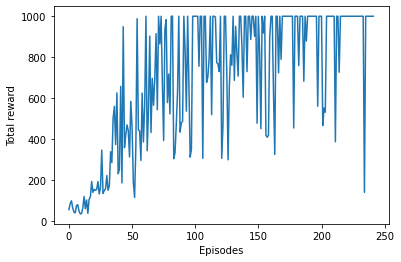

In [13]:
plt.plot(total_rewards)
plt.ylabel('Total reward')
plt.xlabel('Episodes')
plt.show()

Test agent

In [ ]:
total_rewards = []

for i_episode in range(10):
    # choose inital state and action
    state = env.reset()
    action = agent.select_initial_action(state)
    total_reward = 0
    
    for t in range(1000):
        env.render()
        # Take action and observe reward, next_state
        next_state, reward, done, info = env.step(action)
        action = agent.observe(state, action, reward, next_state, done)
        total_reward += reward
        if done:
            break
        state = next_state
    
    total_rewards.append(total_reward)
    print("Episode finished after {}".format(t+1))
    
    
np.mean(total_rewards)
    
env.close()